# Data Cleaning and Pre-processing

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import csv
import datetime
from datetime import datetime
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [98]:
#remove columns
def remove_columns(dataset, to_remove):
    purchase_data = dataset.copy()
    
    ### BEGIN SOLUTION    
    purchase_data = dataset.drop(to_remove, axis=1)
    ### END SOLUTION
    
    return purchase_data

# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
    
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['Date', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
#return aggregate observation of sum for unique carrier
def aggregate_observations(dataset):
    flight_data = dataset.copy()
    
    flight_data = flight_data.groupby( ['UniqueCarrier']).sum()
    flight_data = flight_data.add_suffix('_Sum').reset_index()
    
    return flight_data

#Write a function that replaces missing values with the mean value:
def replace_missing_values(dataset, variable):
    transformed_data = dataset.copy()
    
    ### BEGIN SOLUTION    
    # We first calculate the mean
    mean = np.nanmean(transformed_data[variable])
    
    # Next, we fill in the NAs with the value
    transformed_data[variable] = transformed_data[variable].fillna(mean)
    ### END SOLUTION
    
    return transformed_data

def plotDistance(data,flag,nbims):
    figsize=(10,10)
    
    #historgram of distance travelled
    plt.style.use('fivethirtyeight')
   
    plt.hist(data.dropna(),bins = nbims)
    if(flag == 'True'):
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.xlabel('Distance travelled'); plt.ylabel('Frequency');
    plt.title('Distribution of Distance Travelled');
    plt.show();

def standardise_variable(dataset, variables):
    normalised_data = dataset.copy()
    
    ### BEGIN SOLUTION    
    # We import the appropriate code
    from sklearn.preprocessing import StandardScaler
    
    # We apply the standard scaler to values of the variables that are inputted
    ss = StandardScaler()
    norm_data = ss.fit_transform(normalised_data[variables].values)
    normalised_data[to_normalise] = norm_data
    ### END SOLUTION
    
    return normalised_data

def transform_categorical_variables(fixed_id_data, to_transform):
    transformed_data = fixed_id_data.copy()
    
    ### BEGIN SOLUTION    
    # We loop all the variables we want to transform, and to so by introducing dummy variables
    for var in to_transform:
        transformed_data = pd.concat([transformed_data.drop(var, axis=1), pd.get_dummies(transformed_data[var].values, prefix=var, drop_first=True)], axis=1)
    ### END SOLUTION
    
    return transformed_data

from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["NOT DELAY", "DELAY"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["NOT DELAY", "DELAY"])
    plt.yticks(np.arange(2) + 0.5, ["NOT DELAY", "DELAY"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [3]:
df_initial = pd.read_csv('flights_2008.csv')
df=df_initial.copy()

In [4]:
#Summary of the dataset
df=df_initial.copy()
print("Number of rows in the dataset:", len(df))
print("\nThese are the various airline carriers (you can find their descriptions through the link):")
print(df['UniqueCarrier'].value_counts())
print("\nWe are of course interested in column 'Cancelled'.")
print(df['Cancelled'].value_counts())

Number of rows in the dataset: 1936758

These are the various airline carriers (you can find their descriptions through the link):
WN    377602
AA    191865
MQ    141920
UA    141426
OO    132433
DL    114238
XE    103663
CO    100195
US     98425
EV     81877
NW     79108
FL     71284
YV     67063
B6     55315
OH     52657
9E     51885
AS     39293
F9     28269
HA      7490
AQ       750
Name: UniqueCarrier, dtype: int64

We are of course interested in column 'Cancelled'.
0    1936125
1        633
Name: Cancelled, dtype: int64


In [5]:
#Cleaning/format Data

#1. Remove duplicates - Ensure there's no duplicate in the data
df.drop_duplicates()

#2. Concatenate year, month and day into one column, and remove the unnecessary columns 
df=df.rename(columns={"DayofMonth": "day"})
df['Date']=pd.to_datetime(df[['Month','day','Year']])

#3. Convert Departure Time
import datetime

format_heure(1230)
df['DepTime'] = df_initial['DepTime'].apply(format_heure)
df['ArrTime'] = df_initial['ArrTime'].apply(format_heure)

In [6]:
#If the flights cancelled, fill the delay columns with 0:

df.loc[df['Cancelled'] == 1, 'ArrTime'] = 0
df.loc[df['Cancelled'] == 1, 'CarrierDelay'] = 0
df.loc[df['Cancelled'] == 1, 'WeatherDelay'] = 0
df.loc[df['Cancelled'] == 1, 'NASDelay'] = 0
df.loc[df['Cancelled'] == 1, 'SecurityDelay'] = 0
df.loc[df['Cancelled'] == 1, 'LateAircraftDelay'] = 0
df.loc[df['Cancelled'] == 1, 'AirTime'] = 0
df.loc[df['Cancelled'] == 1, 'ArrDelay'] = 0
df.loc[df['Cancelled'] == 1, 'ActualElapsedTime'] = 0
df.loc[df['Cancelled'] == 1, 'TaxiIn'] = 0
df.loc[df['Cancelled'] == 1, 'TaxiOut'] = 0
df.loc[df['Diverted'] == 1, 'ArrTime'] = 0
df.loc[df['Diverted'] == 1, 'CarrierDelay'] = 0
df.loc[df['Diverted'] == 1, 'WeatherDelay'] = 0
df.loc[df['Diverted'] == 1, 'NASDelay'] = 0
df.loc[df['Diverted'] == 1, 'SecurityDelay'] = 0
df.loc[df['Diverted'] == 1, 'LateAircraftDelay'] = 0
df.loc[df['Diverted'] == 1, 'AirTime'] = 0
df.loc[df['Diverted'] == 1, 'ArrDelay'] = 0
df.loc[df['Diverted'] == 1, 'ActualElapsedTime'] = 0
df.loc[df['Diverted'] == 1, 'TaxiIn'] = 0
df.loc[df['Diverted'] == 1, 'TaxiOut'] = 0

In [7]:
#fill Nan with mean
from pandas.testing import assert_frame_equal
df_clean = df.copy()  

mean = np.nanmean(df_clean['CarrierDelay'])
df_clean['CarrierDelay'] = df_clean['CarrierDelay'].fillna(mean)

mean = np.nanmean(df_clean['WeatherDelay'])
df_clean['WeatherDelay'] = df_clean['WeatherDelay'].fillna(mean)

mean = np.nanmean(df_clean['NASDelay'])
df_clean['NASDelay'] = df_clean['NASDelay'].fillna(mean)

mean = np.nanmean(df_clean['SecurityDelay'])
df_clean['SecurityDelay'] = df_clean['SecurityDelay'].fillna(mean)

mean = np.nanmean(df_clean['LateAircraftDelay'])
df_clean['LateAircraftDelay'] = df_clean['LateAircraftDelay'].fillna(mean)

In [8]:
#There were empty CRSElapsedTime. Calculate the CRSElapsedTime for all rows

df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'CRSDepTime')
df['SCHEDULED_ARRIVAL'] = create_flight_time(df, 'CRSArrTime')
df['CRSElapsedTime_new']=(df.SCHEDULED_ARRIVAL-df.SCHEDULED_DEPARTURE).astype('timedelta64[m]')

In [9]:
df_clean['CRSElapsedTime_new']=df['CRSElapsedTime_new']

In [76]:
#Lastly, remove unnecessary columns and drop rows with remaining Nan and unnecessary cols
delayed_flights=df_clean_1.copy()
delayed_flights.dropna(subset = ["TailNum"], inplace=True)
to_remove=['Year']
delayed_flights=remove_columns(delayed_flights,to_remove)

In [78]:
#add delayed or not column

delayed = []
for i, j in enumerate(delayed_flights["ArrDelay"]):
    if (j > 15):
        delayed.append(1)
    else:
        delayed.append(0)

delayed_flights['Delayed']=delayed

In [80]:
delayed_flights["Delayed"].value_counts()

1    1215010
0     721743
Name: Delayed, dtype: int64

In [87]:
total_scheduled=len(delayed_flights)
print("Total scheduled flights:",total_scheduled)
print("Total delayed flights:",sum(delayed_flights["Delayed"]))
print("Total on-time flights:",total_scheduled-sum(delayed_flights["Delayed"]))

Total scheduled flights: 1878364
Total delayed flights: 1181049
Total on-time flights: 697315


In [81]:
#final clean data
print(delayed_flights.isna().sum())

Month                 0
day                   0
DayOfWeek             0
DepTime               0
CRSDepTime            0
ArrTime               0
CRSArrTime            0
UniqueCarrier         0
FlightNum             0
TailNum               0
ActualElapsedTime     0
AirTime               0
ArrDelay              0
DepDelay              0
Origin                0
Dest                  0
Distance              0
TaxiIn                0
TaxiOut               0
Cancelled             0
CancellationCode      0
Diverted              0
CarrierDelay          0
WeatherDelay          0
NASDelay              0
SecurityDelay         0
LateAircraftDelay     0
Date                  0
CRSElapsedTime_new    0
Delayed               0
dtype: int64


In [82]:
delayed_flights.to_csv('Clean_Data.csv',date_format='%Y-%m-%d %H:%M:%S')

In [83]:
delayed_flights = pd.read_csv('Clean_Data.csv')
delayed_flights.head()

,Unnamed: 0,Month,day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date,CRSElapsedTime_new,Delayed
0,0,1,3,4,20:03:00,1955,22:11:00,2225,WN,335,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,150.0,0
1,1,1,3,4,07:54:00,735,10:02:00,1000,WN,3231,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,145.0,0
2,2,1,3,4,06:28:00,620,08:04:00,750,WN,448,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,90.0,0
3,3,1,3,4,18:29:00,1755,19:59:00,1925,WN,3920,...,N,0,2.000000,0.000000,0.000000,0.000000,32.000000,2008-01-03 00:00:00,90.0,1
4,4,1,3,4,19:40:00,1915,21:21:00,2110,WN,378,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,115.0,0


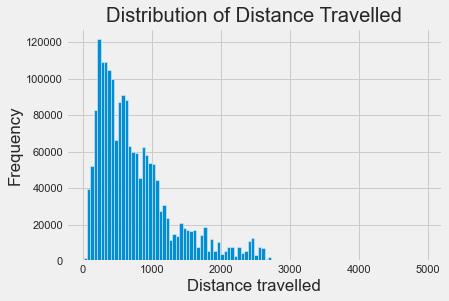

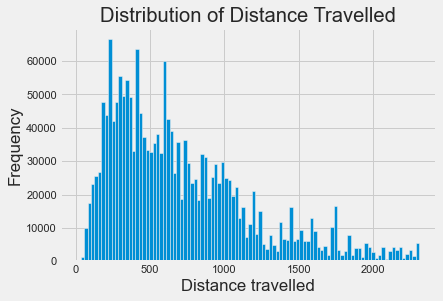

In [84]:
#Removing outliers
plotDistance(delayed_flights['Distance'], False, 100)

first_quartile = delayed_flights['Distance'].describe()['25%']
third_quartile = delayed_flights['Distance'].describe()['75%']

interquartile_range = third_quartile-first_quartile

delayed_flights = delayed_flights[(delayed_flights['Distance']<(first_quartile + 3*interquartile_range))]

plotDistance(delayed_flights['Distance'], False, 100)


In [85]:
#normalised non binary data
from pandas.testing import assert_frame_equal
from sklearn.preprocessing import StandardScaler

normalised_data = delayed_flights.copy()

to_normalise = ['Month', 'day', 'DayOfWeek', 'ActualElapsedTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']    
ss = StandardScaler()
norm_data = ss.fit_transform(normalised_data[to_normalise].values)
normalised_data[to_normalise] = norm_data

assert normalised_data.equals(standardise_variable(delayed_flights, to_normalise))

# Correlation Matrix

In [44]:
#Correlation matrix
#! pip install dython
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(normalised_data)
categorical_features

['DepTime',
 'ArrTime',
 'UniqueCarrier',
 'TailNum',
 'Origin',
 'Dest',
 'CancellationCode',
 'Date']

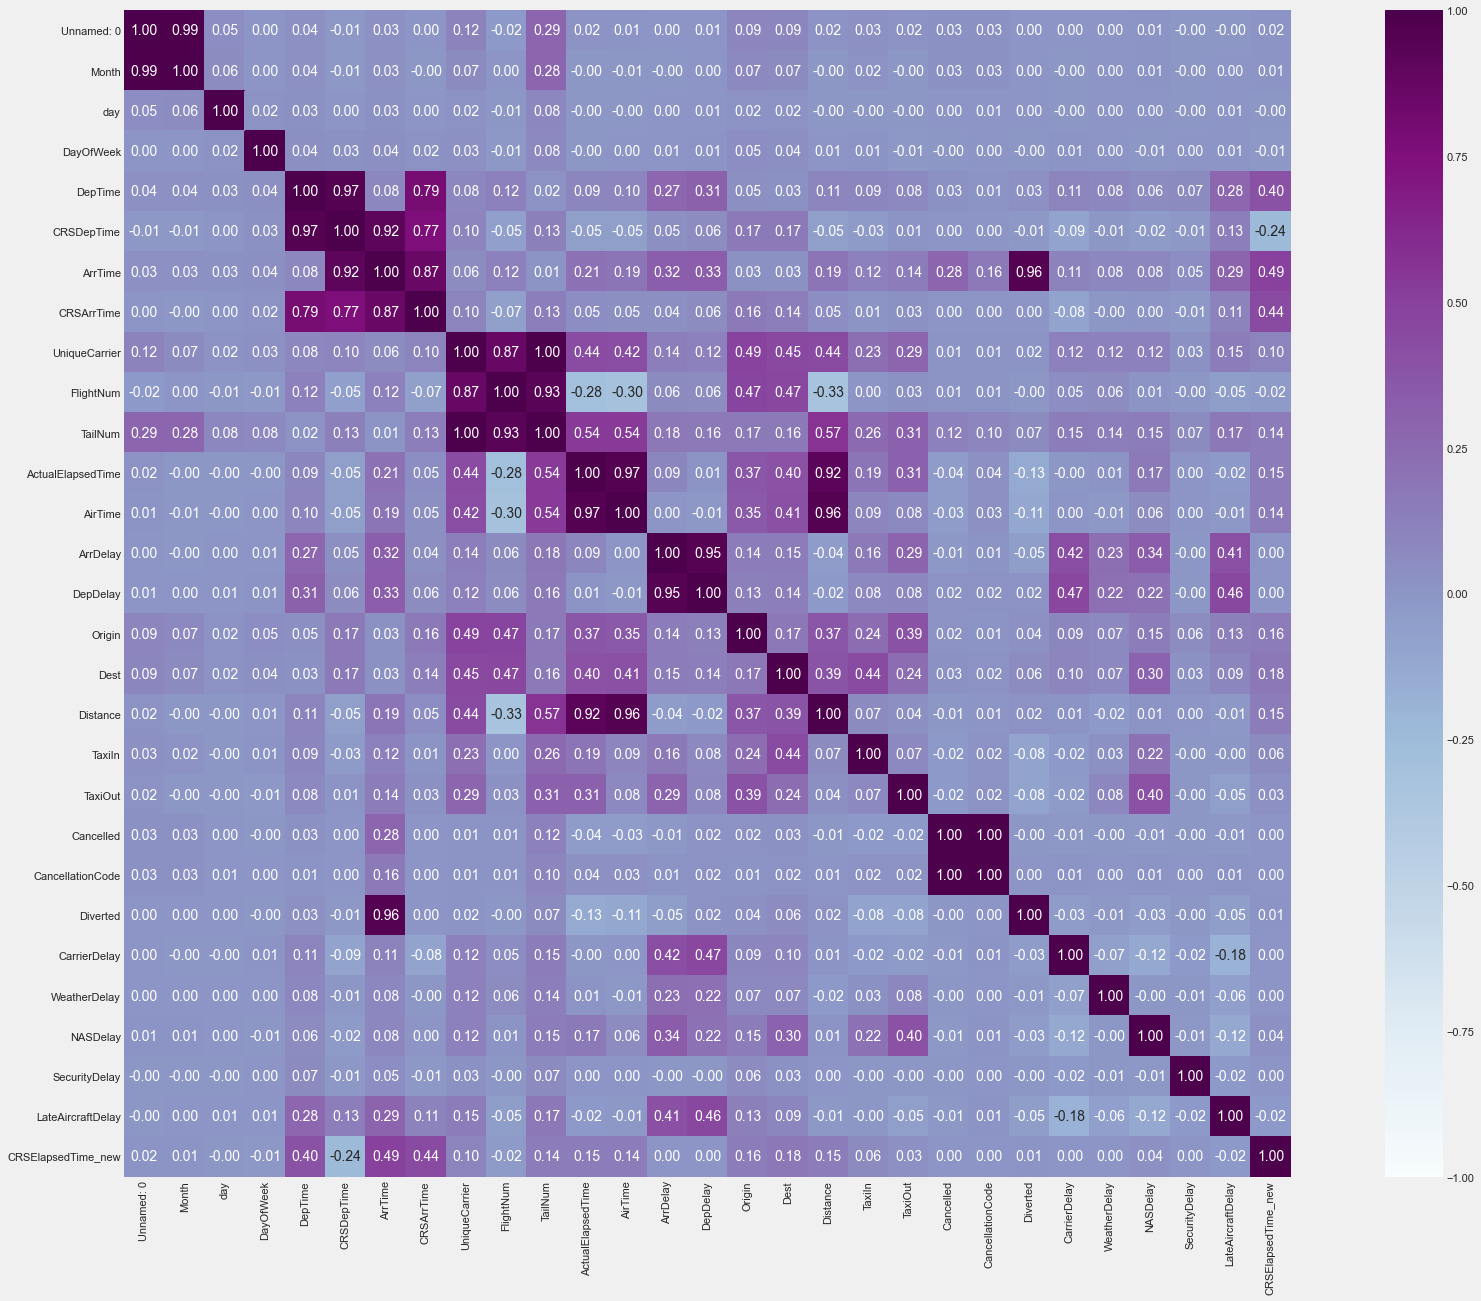

In [46]:
to_remove=['Date']
normalised_data=remove_columns(normalised_data,to_remove)

from dython.nominal import associations
complete_correlation= associations(normalised_data, figsize=(30,20),cmap="BuPu",)

In [48]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,Unnamed: 0,Month,day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,CRSElapsedTime_new
Unnamed: 0,1.00,0.99,0.05,0.00,0.04,-0.01,0.03,0.00,0.12,-0.02,0.29,0.02,0.01,0.00,0.01,0.09,0.09,0.02,0.03,0.02,0.03,0.03,0.00,0.00,0.00,0.01,-0.00,-0.00,0.02
Month,0.99,1.00,0.06,0.00,0.04,-0.01,0.03,-0.00,0.07,0.00,0.28,-0.00,-0.01,-0.00,0.00,0.07,0.07,-0.00,0.02,-0.00,0.03,0.03,0.00,-0.00,0.00,0.01,-0.00,0.00,0.01
day,0.05,0.06,1.00,0.02,0.03,0.00,0.03,0.00,0.02,-0.01,0.08,-0.00,-0.00,0.00,0.01,0.02,0.02,-0.00,-0.00,-0.00,0.00,0.01,0.00,-0.00,0.00,0.00,-0.00,0.01,-0.00
DayOfWeek,0.00,0.00,0.02,1.00,0.04,0.03,0.04,0.02,0.03,-0.01,0.08,-0.00,0.00,0.01,0.01,0.05,0.04,0.01,0.01,-0.01,-0.00,0.00,-0.00,0.01,0.00,-0.01,0.00,0.01,-0.01
DepTime,0.04,0.04,0.03,0.04,1.00,0.97,0.08,0.79,0.08,0.12,0.02,0.09,0.10,0.27,0.31,0.05,0.03,0.11,0.09,0.08,0.03,0.01,0.03,0.11,0.08,0.06,0.07,0.28,0.40
CRSDepTime,-0.01,-0.01,0.00,0.03,0.97,1.00,0.92,0.77,0.10,-0.05,0.13,-0.05,-0.05,0.05,0.06,0.17,0.17,-0.05,-0.03,0.01,0.00,0.00,-0.01,-0.09,-0.01,-0.02,-0.01,0.13,-0.24
ArrTime,0.03,0.03,0.03,0.04,0.08,0.92,1.00,0.87,0.06,0.12,0.01,0.21,0.19,0.32,0.33,0.03,0.03,0.19,0.12,0.14,0.28,0.16,0.96,0.11,0.08,0.08,0.05,0.29,0.49
CRSArrTime,0.00,-0.00,0.00,0.02,0.79,0.77,0.87,1.00,0.10,-0.07,0.13,0.05,0.05,0.04,0.06,0.16,0.14,0.05,0.01,0.03,0.00,0.00,0.00,-0.08,-0.00,0.00,-0.01,0.11,0.44
UniqueCarrier,0.12,0.07,0.02,0.03,0.08,0.10,0.06,0.10,1.00,0.87,1.00,0.44,0.42,0.14,0.12,0.49,0.45,0.44,0.23,0.29,0.01,0.01,0.02,0.12,0.12,0.12,0.03,0.15,0.10
FlightNum,-0.02,0.00,-0.01,-0.01,0.12,-0.05,0.12,-0.07,0.87,1.00,0.93,-0.28,-0.30,0.06,0.06,0.47,0.47,-0.33,0.00,0.03,0.01,0.01,-0.00,0.05,0.06,0.01,-0.00,-0.05,-0.02


In [88]:
delayed_flights.to_csv('delayed_flights.csv',date_format='%Y-%m-%d %H:%M:%S')

# Split train and test data

In [89]:
df = pd.read_csv('delayed_flights.csv')
df

,Unnamed: 0,Unnamed: 0.1,Month,day,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Date,CRSElapsedTime_new,Delayed
0,0,0,1,3,4,20:03:00,1955,22:11:00,2225,WN,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,150.0,0
1,1,1,1,3,4,07:54:00,735,10:02:00,1000,WN,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,145.0,0
2,2,2,1,3,4,06:28:00,620,08:04:00,750,WN,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,90.0,0
3,3,3,1,3,4,18:29:00,1755,19:59:00,1925,WN,...,N,0,2.000000,0.000000,0.000000,0.000000,32.000000,2008-01-03 00:00:00,90.0,1
4,4,4,1,3,4,19:40:00,1915,21:21:00,2110,WN,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-01-03 00:00:00,115.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878359,1936748,1936753,12,13,6,12:50:00,1220,16:17:00,1552,DL,...,N,0,3.000000,0.000000,0.000000,0.000000,22.000000,2008-12-13 00:00:00,212.0,1
1878360,1936749,1936754,12,13,6,06:57:00,600,09:04:00,749,DL,...,N,0,0.000000,57.000000,18.000000,0.000000,0.000000,2008-12-13 00:00:00,109.0,1
1878361,1936750,1936755,12,13,6,10:07:00,847,11:49:00,1010,DL,...,N,0,1.000000,0.000000,19.000000,0.000000,79.000000,2008-12-13 00:00:00,83.0,1
1878362,1936751,1936756,12,13,6,12:51:00,1240,14:46:00,1437,DL,...,N,0,19.051315,3.678837,14.921318,0.089535,25.127531,2008-12-13 00:00:00,117.0,0


In [92]:
to_remove=['Unnamed: 0','Unnamed: 0.1','ActualElapsedTime','AirTime','Cancelled','DepTime','CRSDepTime','ArrTime','CRSArrTime','CancellationCode','Diverted','Date','CRSElapsedTime_new']
delay=remove_columns(df,to_remove)
delay

,Month,day,DayOfWeek,UniqueCarrier,FlightNum,TailNum,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
0,1,3,4,WN,335,N712SW,-14.0,8.0,IAD,TPA,810,4.0,8.0,19.051315,3.678837,14.921318,0.089535,25.127531,0
1,1,3,4,WN,3231,N772SW,2.0,19.0,IAD,TPA,810,5.0,10.0,19.051315,3.678837,14.921318,0.089535,25.127531,0
2,1,3,4,WN,448,N428WN,14.0,8.0,IND,BWI,515,3.0,17.0,19.051315,3.678837,14.921318,0.089535,25.127531,0
3,1,3,4,WN,3920,N464WN,34.0,34.0,IND,BWI,515,3.0,10.0,2.000000,0.000000,0.000000,0.000000,32.000000,1
4,1,3,4,WN,378,N726SW,11.0,25.0,IND,JAX,688,4.0,10.0,19.051315,3.678837,14.921318,0.089535,25.127531,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878359,12,13,6,DL,1621,N938DL,25.0,30.0,MSP,ATL,906,9.0,18.0,3.000000,0.000000,0.000000,0.000000,22.000000,1
1878360,12,13,6,DL,1631,N3743H,75.0,57.0,RIC,ATL,481,15.0,34.0,0.000000,57.000000,18.000000,0.000000,0.000000,1
1878361,12,13,6,DL,1631,N909DA,99.0,80.0,ATL,IAH,689,8.0,32.0,1.000000,0.000000,19.000000,0.000000,79.000000,1
1878362,12,13,6,DL,1639,N646DL,9.0,11.0,IAD,ATL,533,13.0,13.0,19.051315,3.678837,14.921318,0.089535,25.127531,0


In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

In [95]:
categorical_features=identify_nominal_columns(delay)
categorical_features

['UniqueCarrier', 'TailNum', 'Origin', 'Dest']

In [ ]:
#remove tailnum, origin, dest because this will not be used in model

In [96]:
to_remove=['TailNum', 'Origin', 'Dest']
delay=remove_columns(delay,to_remove)

In [99]:
#transform categorical data

features = ['UniqueCarrier']

y = delay['Delayed']
x = pd.get_dummies(delay[features])

In [102]:
#Split train and test data
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,random_state=10)

print("Number shape train_x dataset: ", train_x.shape)
print("Number shape train_y dataset: ", train_y.shape)
print("Number shape test_x dataset: ", test_x.shape)
print("Number shape test_y dataset: ", test_y.shape)

Number shape train_x dataset:  (1502691, 20)
Number shape train_y dataset:  (1502691,)
Number shape test_x dataset:  (375673, 20)
Number shape test_y dataset:  (375673,)


# SMOTE

In [ ]:
#SMOTE

from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
train_x_sm, train_y_sm = sm.fit_resample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(train_x_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(train_y_sm.shape))

print("After OverSampling, counts of label '1': {}".format(sum(train_y_sm==1)))
print("After OverSampling, counts of label '0': {}".format(sum(train_y_sm==0)))



# Logistic Regression

In [103]:
#logistic regression model

logistic_regression_model= LogisticRegression()
logistic_regression_model.fit(train_x,train_y)
logistic_regression_pred=logistic_regression_model.predict(test_x)

Test Accuracy: 63.01%


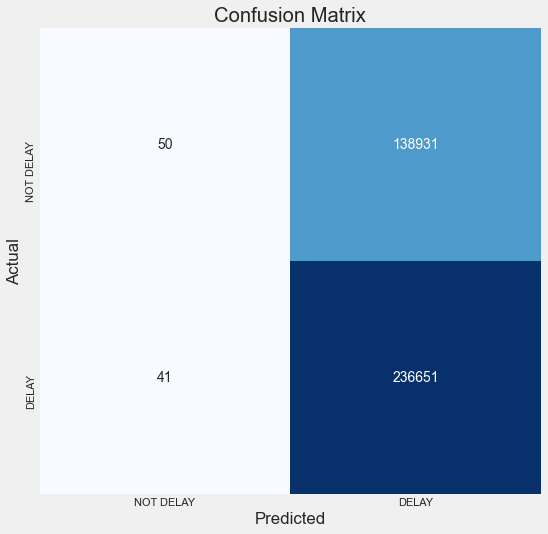

Classification Report:
----------------------
               precision    recall  f1-score   support

   NOT DELAY       0.55      0.00      0.00    138981
       DELAY       0.63      1.00      0.77    236692

    accuracy                           0.63    375673
   macro avg       0.59      0.50      0.39    375673
weighted avg       0.60      0.63      0.49    375673



In [104]:
evaluate_model(logistic_regression_model, test_x, test_y)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

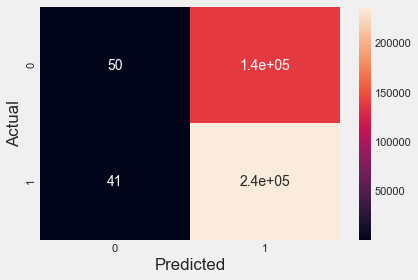

In [105]:
confusion_matrix = pd.crosstab(test_y,logistic_regression_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [106]:
from sklearn import metrics

print('Accuracy: ',metrics.accuracy_score(test_y, logistic_regression_pred))
plt.show()

logistic_regression_model.score(test_x, test_y)

Accuracy:  0.6300718976343789


0.6300718976343789

In [107]:
from sklearn.metrics import roc_auc_score
probabilities = logistic_regression_model.predict_proba(test_x)

roc_auc_score(test_y,probabilities[:,1])

0.5769856211074537

In [108]:
from sklearn.metrics import roc_auc_score
probabilities = logistic_regression_model.predict_proba(test_x)

roc_auc_score(test_y,probabilities[:,1])

0.5769856211074537

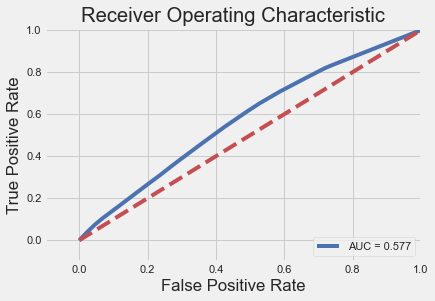

In [110]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

tmp = logistic_regression_model.fit(train_x, train_y.ravel())

y_pred_sample_score = tmp.decision_function(test_x)


fpr, tpr, thresholds = roc_curve(test_y, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest Classification

In [111]:
#Random Forest model

random_forest_model = RandomForestClassifier(n_estimators=100,max_depth =5, random_state=13)
random_forest_model.fit(train_x,train_y)
random_forest_pred = random_forest_model.predict(test_x)

In [118]:
from sklearn import metrics

print('Accuracy: ',metrics.accuracy_score(test_y, random_forest_pred))
plt.show()

logistic_regression_model.score(test_x, test_y)

Accuracy:  0.6300479406292174


0.6300718976343789

In [133]:
from sklearn.metrics import roc_auc_score
probabilities = random_forest_model.predict_proba(test_x)

roc_auc_score(test_y,probabilities[:,1])

0.5759635822893221

# Decision Tree

In [130]:
decision_tree_model = DecisionTreeRegressor(random_state=1)
decision_tree_model.fit(train_x,train_y)
decision_tree_pred = decision_tree_model.predict(test_x)

In [131]:
from sklearn import metrics

decision_tree_model.score(test_x, test_y)

0.01875290257096429